<a href="https://colab.research.google.com/github/peuape/deep_learning/blob/main/%E6%83%85%E5%A0%B1%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00


①エポック数２０、工夫なし

In [ ]:

import numpy as np
import tensorflow as tf
import transformers
from sklearn.metrics import accuracy_score
import csv
import matplotlib.pyplot as plt



#日本語の訓練データ（単語同士に分かれ、単語同士の関係を学習したデータ）
model_name = "cl-tohoku/bert-base-japanese"
#上記のデータを単語に分けたり、各単語を数値化できるようなモデルを作成
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

#訓練データ、テストデータ（後で分ける）
g = open("/content/情報 最終課題 教師データver5添削済み.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(g)
train_labels = []
for row in dataReader:
    if row[1].strip():
        train_labels.append(int(row[1]))
g.close()

f = open("/content/情報 最終課題 教師データver5添削済み.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(f)

train_texts = []

for row in dataReader:
    if len(train_texts) < len(train_labels):
        train_texts.append(row[0])
    else:
        pass
f.close()

print(len(train_texts), len(train_labels))

# テキストのリストをtransformers用の入力データに変換
def to_features(texts, max_length):
    shape = (len(texts), max_length)
    input_ids = np.zeros(shape, dtype="int32")
    attention_mask = np.zeros(shape, dtype="int32")
    token_type_ids = np.zeros(shape, dtype="int32")
    for i, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(text, max_length=max_length, pad_to_max_length=True)
        input_ids[i] = encoded_dict["input_ids"]
        attention_mask[i] = encoded_dict["attention_mask"]
        token_type_ids[i] = encoded_dict["token_type_ids"]
    return [input_ids, attention_mask, token_type_ids]

# 単一テキストをクラス分類するモデルの構築
def build_model(model_name, num_classes, max_length):
    input_shape = (max_length, )
    input_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    #　model_nameを特徴量に変化させる
    bert_model = transformers.TFBertModel.from_pretrained(model_name)
    pooler_output = bert_model.layers[0](
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    #model.compileを動かすための要素を揃える
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(pooler_output[1])
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[output])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
    #model.compileを動かす→inputsに対して、outputsを出す
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

num_classes = 2
max_length = 15
batch_size = 10
epochs = 20

x_train = to_features(train_texts, max_length)
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
model = build_model(model_name, num_classes=num_classes, max_length=max_length)


history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(len(loss)), loss, "b", label="train")
plt.plot(range(len(val_loss)), val_loss, "r", label="validate")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(range(len(acc)), acc, "b", label="train")
plt.plot(range(len(val_acc)), val_acc, "r", label="validate")
plt.legend()
plt.title("accuracy")
plt.show()


②https://ai-scholar.tech/articles/bert/bert-fine-tuning

・バイアス補正あり、学習率を2e-5に設定したADAMを利用

・訓練は20エポック行われ、学習率は最初の10%は線形に増加し、以降はゼロに減衰

・その他のハイパーパラメータは変更しない

に基づき上のコードを変更

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In

332 332


Some layers from the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']

Epoch 1/20
27/27 [==============================] - 62s 353ms/step - loss: 0.7665 - acc: 0.5396 - val_loss: 0.6393 - val_acc: 0.5970 - lr: 2.0000e-05
Epoch 2/20
27/27 [==============================] - 4s 147ms/step - loss: 0.5690 - acc: 0.7208 - val_loss: 0.5981 - val_acc: 0.7164 - lr: 2.5000e-05
Epoch 3/20
27/27 [==============================] - 3s 114ms/step - loss: 0.3132 - acc: 0.8642 - val_loss: 0.6115 - val_acc: 0.7313 - lr: 2.0000e-05
Epoch 4/20
27/27 [==============================] - 3s 118ms/step - loss: 0.1093 - acc: 0.9774 - val_loss: 0.6767 - val_acc: 0.7463 - lr: 1.8889e-05
Epoch 5/20
27/27 [==============================] - 4s 161ms/step - loss: 0.0289 - acc: 0.9962 - val_loss: 0.7935 - val_acc: 0.7015 - lr: 1.7778e-05
Epoch 6/20
27/27 [==============================] - 3s 123ms/step - loss: 0.0153 - acc: 0.9962 - val_loss: 0.9572 - val_acc: 0.6866 - lr: 1.6667e-05
Epoch 7/20
27/27 [==============================] - 4s 155ms/step - loss: 0.0083 - acc: 1.0000 - val_loss

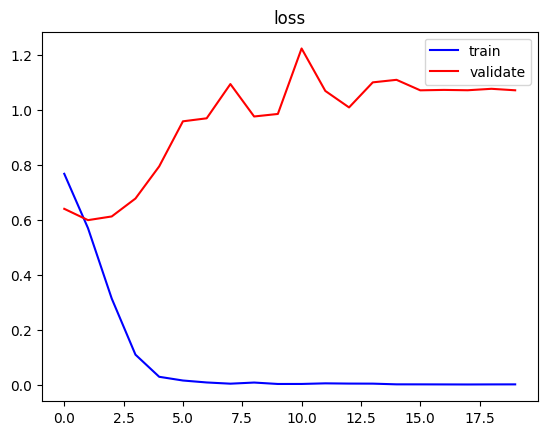

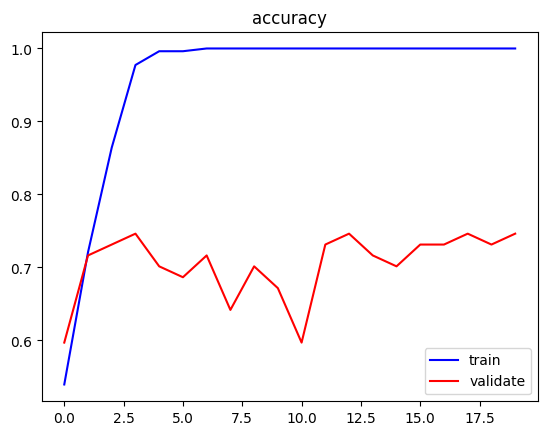

In [ ]:

import numpy as np
import tensorflow as tf
import transformers
from sklearn.metrics import accuracy_score
import csv
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler



#日本語の訓練データ（単語同士に分かれ、単語同士の関係を学習したデータ）
model_name = "cl-tohoku/bert-base-japanese"
#上記のデータを単語に分けたり、各単語を数値化できるようなモデルを作成
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

#訓練データ、テストデータ（後で分ける）
g = open("/content/情報 最終課題 教師データver5添削済み.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(g)
train_labels = []
for row in dataReader:
    if row[1].strip():
        train_labels.append(int(row[1]))
g.close()

f = open("/content/情報 最終課題 教師データver5添削済み.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(f)

train_texts = []

for row in dataReader:
    if len(train_texts) < len(train_labels):
        train_texts.append(row[0])
    else:
        pass
f.close()

print(len(train_texts), len(train_labels))

# テキストのリストをtransformers用の入力データに変換
def to_features(texts, max_length):
    shape = (len(texts), max_length)
    input_ids = np.zeros(shape, dtype="int32")
    attention_mask = np.zeros(shape, dtype="int32")
    token_type_ids = np.zeros(shape, dtype="int32")
    for i, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(text, max_length=max_length, pad_to_max_length=True)
        input_ids[i] = encoded_dict["input_ids"]
        attention_mask[i] = encoded_dict["attention_mask"]
        token_type_ids[i] = encoded_dict["token_type_ids"]
    return [input_ids, attention_mask, token_type_ids]

# 単一テキストをクラス分類するモデルの構築
def build_model(model_name, num_classes, max_length):
    input_shape = (max_length, )
    input_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32)
    bert_model = transformers.TFBertModel.from_pretrained(model_name)
    pooler_output = bert_model.layers[0](
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(pooler_output[1])
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[output])


    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model


num_classes = 2
max_length = 15
batch_size = 10
epochs = 20




#train_textsをtransformers用の入力データに変換
x_train = to_features(train_texts, max_length)
#train_labelsを何かに変換
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
model = build_model(model_name, num_classes=num_classes, max_length=max_length)


def lr_schedule(epoch):
    if epoch < 0.1 * epochs:
        return 2e-5 + epoch * (3e-5 - 2e-5) / (0.1 * epochs)
    else:
        return 2e-5 - (epoch - 0.1 * epochs) * 2e-5 / (0.9 * epochs)

num_classes = 2
max_length = 15
batch_size = 10
epochs = 20

x_train = to_features(train_texts, max_length)
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
model = build_model(model_name, num_classes=num_classes, max_length=max_length)


lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[lr_scheduler]
)


loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(len(loss)), loss, "b", label="train")
plt.plot(range(len(val_loss)), val_loss, "r", label="validate")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(range(len(acc)), acc, "b", label="train")
plt.plot(range(len(val_acc)), val_acc, "r", label="validate")
plt.legend()
plt.title("accuracy")
plt.show()



以下では男女判別が人間にも難しい文も含むデータを予測。予測の中身を見てみる。

In [ ]:


h = open("/content/情報 テストデータ.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(h)
test_texts = []
for row in dataReader:
    test_texts.append(row[0])
h.close()

i = open("/content/情報 テストデータ.csv", 'r', encoding='shift-jis')
dataReader = csv.reader(i)
test_labels = []
for row in dataReader:
    test_labels.append(int(row[1]))
h.close()

x_test = to_features(test_texts, max_length)
y_test = np.asarray(test_labels)
y_preda = model.predict(x_test)
y_pred = np.argmax(y_preda, axis=1)
print("Accuracy: %.5f" % accuracy_score(y_test, y_pred))
for i in range(len(test_texts)):
  print(y_preda[i],'Prediction:', y_pred[i], 'Answer:', y_test[i],test_texts[i])



1/1 [==============================] - 4s 4s/step
Accuracy: 0.60000
[0.22236994 0.77763003] Prediction: 1 Answer: 0 セカオワのZeppツアー当たった！！
[0.00828665 0.9917134 ] Prediction: 1 Answer: 0 ゼルダも情報も終わったわ
[0.9964223 0.0035777] Prediction: 0 Answer: 0 まじ一般組と学力差しか感じなくて辛い
[0.01032539 0.9896746 ] Prediction: 1 Answer: 0 やば、アツすぎる
[0.0059488  0.99405116] Prediction: 1 Answer: 0 明日は神戸行って明後日は大阪行くか
[0.8614486  0.13855137] Prediction: 0 Answer: 0 まる5時間コールして最後に衣織ちゃんに愛叫びまくったら喉終わった
[0.00746236 0.9925377 ] Prediction: 1 Answer: 1 いっしょにしあわせになろうね
[0.78590167 0.21409838] Prediction: 0 Answer: 1 さくらちゃんの真似した！
[0.99353665 0.00646331] Prediction: 0 Answer: 0 4ヶ月前と変わらず最寄り駅に１人劇おじさんがいて、ああ帰って来たんだなと感じた
[0.00917567 0.99082434] Prediction: 1 Answer: 1 私のことフォローしたら、ワンピ全巻読むのが義務ですからね。
[3.3725300e-04 9.9966276e-01] Prediction: 1 Answer: 1 夜は花火大会……と思っていたけど雨かな？
[0.06611414 0.9338858 ] Prediction: 1 Answer: 0 明日提出のALESAのShort Paperまだ0文字でおもろい
[0.00469166 0.99530834] Prediction: 1 Answer: 1 私って動物に例えると何顔なんだ？
[0.81228566 0.18771438] 